In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from numba import njit

data_dir = 'Data\RFpredictions'

# Load Parquet files into data_frames dictionary
data_frames = {}
files = [file for file in os.listdir(data_dir) if file.endswith('.parquet')]
for file in tqdm(files, desc="Loading Parquet files"):
    ticker = file.split('.')[0]
    data_frames[ticker] = pd.read_parquet(os.path.join(data_dir, file))

@njit
def calculate_dynamic_weights(volatility, mean_volatility, std_volatility):
    if std_volatility == 0:
        return np.array([0.25, 0.25, 0.25, 0.25])
    
    z_score = (volatility - mean_volatility) / std_volatility
    weights = np.array([0.25 - 0.1*z_score, 0.25 - 0.05*z_score, 0.25 + 0.05*z_score, 0.25 + 0.1*z_score])
    weights = np.maximum(np.minimum(weights, 1), 0)  # This replaces np.clip
    return weights / np.sum(weights)

@njit
def calculate_weighted_returns_fast(returns, volatility, mean_volatility, std_volatility):
    weighted_returns = np.zeros(len(returns))
    for i in range(21, len(returns)):
        weights = calculate_dynamic_weights(volatility[i], mean_volatility[i], std_volatility[i])
        weighted_returns[i] = np.sum(returns[i] * weights)
    return weighted_returns

def process_stock_data(df):
    df['Daily_Return'] = df['Close'].pct_change().fillna(method='bfill').round(3)
    df['Weekly_Return'] = df['Close'].pct_change(5).fillna(method='bfill').round(3)
    df['Monthly_Return'] = df['Close'].pct_change(21).fillna(method='bfill').round(3)
    df['Yearly_Return'] = df['Close'].pct_change(252).fillna(method='bfill').round(3)

    df['Volatility'] = df['Daily_Return'].rolling(window=21).std().fillna(method='bfill')
    df['Mean_Volatility'] = df['Volatility'].rolling(window=21).mean().fillna(method='bfill')
    df['Volatility_Std'] = df['Volatility'].rolling(window=21).std().fillna(method='bfill')

    returns = np.column_stack((df['Daily_Return'], df['Weekly_Return'], df['Monthly_Return'], df['Yearly_Return']))
    volatility = df['Volatility'].values
    mean_volatility = df['Mean_Volatility'].values
    std_volatility = df['Volatility_Std'].values

    df['Weighted_Return'] = calculate_weighted_returns_fast(returns, volatility, mean_volatility, std_volatility)
    df['Weighted_Return'] = df['Weighted_Return'].round(3)

    return df

# Process all stocks
for ticker, df in tqdm(data_frames.items(), desc="Processing stocks"):
    data_frames[ticker] = process_stock_data(df)

returns_df = pd.DataFrame({ticker: df['Weighted_Return'] for ticker, df in data_frames.items()}).fillna(method='bfill')

correlation_matrix = returns_df.corr().fillna(method='bfill').fillna(method='ffill')

scaler = StandardScaler()
scaled_correlation = scaler.fit_transform(correlation_matrix)

# Perform clustering
kmeans = KMeans(n_clusters=8, random_state=0, n_init=10)
clusters = kmeans.fit_predict(scaled_correlation)

correlation_matrix_df = pd.DataFrame(correlation_matrix)
correlation_matrix_df['Cluster'] = clusters

# Elbow Method
inertia = []
for k in tqdm(range(2, 20), desc="Elbow Method"):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(scaled_correlation)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 20), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# Silhouette Score
silhouette_scores = []
for k in tqdm(range(2, 20), desc="Silhouette Score"):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels = kmeans.fit_predict(scaled_correlation)
    silhouette_scores.append(silhouette_score(scaled_correlation, labels))

plt.figure(figsize=(10, 6))
plt.plot(range(2, 20), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Optimal Number of Clusters')
plt.show()

clustered_assets = correlation_matrix_df[['Cluster']].reset_index()
clustered_assets.columns = ['Ticker', 'Cluster']

def calculate_group_correlations_vectorized(correlation_matrix, clustered_assets):
    corr_array = correlation_matrix.values
    unique_clusters = clustered_assets['Cluster'].unique()
    cluster_indices = {cluster: clustered_assets.index[clustered_assets['Cluster'] == cluster].tolist() 
                       for cluster in unique_clusters}
    
    result = pd.DataFrame(index=correlation_matrix.index, 
                          columns=[f'correlation_{cluster}' for cluster in unique_clusters])
    
    for cluster in tqdm(unique_clusters, desc="Calculating Group Correlations"):
        indices = cluster_indices[cluster]
        cluster_correlations = corr_array[:, indices].mean(axis=1)
        result[f'correlation_{cluster}'] = cluster_correlations
    
    return result

group_correlations = calculate_group_correlations_vectorized(correlation_matrix, clustered_assets)

clustered_assets = clustered_assets.merge(group_correlations, left_on='Ticker', right_index=True)

mean_intra_group_corr = clustered_assets.groupby('Cluster')[group_correlations.columns].mean().mean(axis=1)
clustered_assets['mean_intragroup_correlation'] = clustered_assets['Cluster'].map(mean_intra_group_corr)
clustered_assets['diff_to_mean_group_corr'] = clustered_assets.apply(
    lambda row: row[f'correlation_{row.Cluster}'] - row['mean_intragroup_correlation'], axis=1)

reordered_columns = ['Ticker', 'Cluster', 'mean_intragroup_correlation', 'diff_to_mean_group_corr'] + list(group_correlations.columns)
clustered_assets = clustered_assets[reordered_columns].round(5)

clustered_assets.to_parquet('Correlations.parquet', index=False)

pd.set_option('display.max_rows', None)
print(clustered_assets[['Ticker', 'Cluster']])

print("Correlations saved to 'Correlations.parquet'.")

            BACKTEST SUMMARY METRICS          
Number of Trades:           176
Win Rate (%):               61.36
Average PnL (%):            2.15
Median PnL (%):             0.49
Max PnL (%):                89.74
Min PnL (%):                -8.65
Average Days Held:          6.28
Median Days Held:           7.00
Start Account Value:        nan
Final Account Value:        17580.24
Total Return (%):           nan
Max Drawdown (%):           -3.22



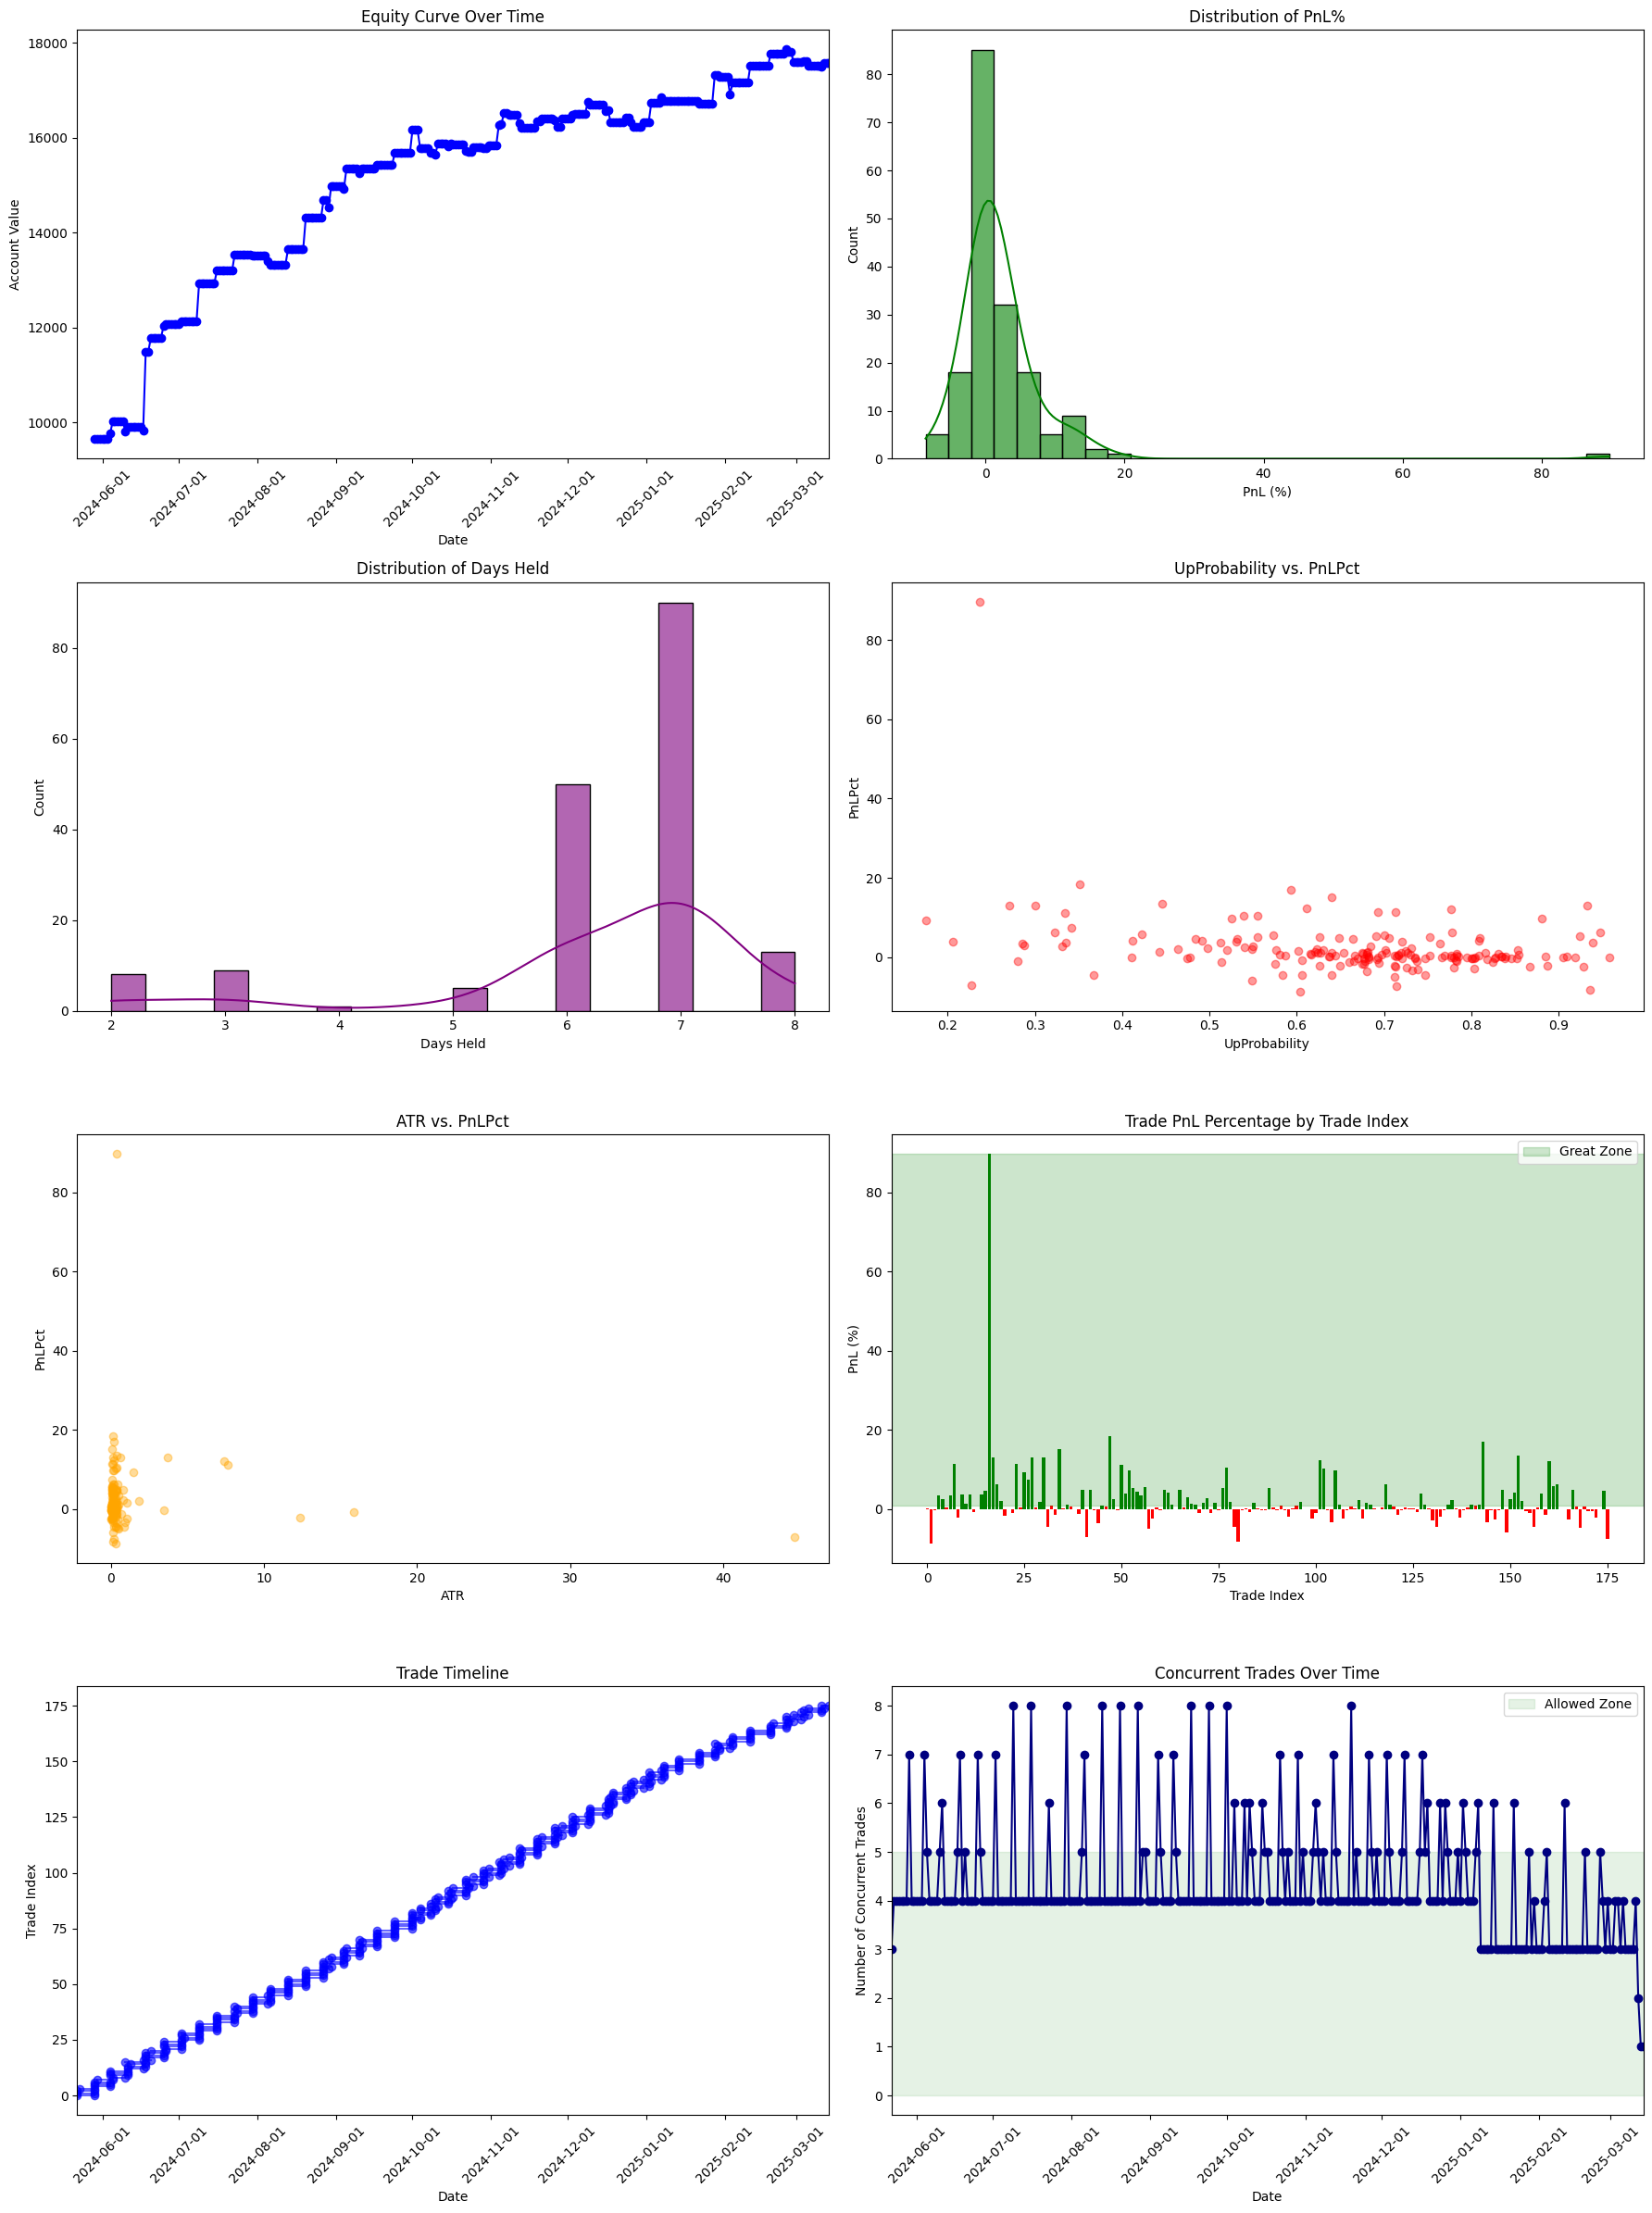

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# ==================================================
# 1) Load and Prepare Data
# ==================================================
df = pd.read_parquet('trade_history.parquet')
df['EntryDate'] = pd.to_datetime(df['EntryDate'])
df['ExitDate']  = pd.to_datetime(df['ExitDate'])

# Filter out any rows with NaT dates if necessary
df = df.dropna(subset=['EntryDate', 'ExitDate'])

# If needed, ensure there's no date prior to your real start
# df = df[df['EntryDate'] >= '2020-01-01']  # example date cutoff

# ==================================================
# 2) Calculate Concurrency & Equity Curve
# ==================================================
min_d = df['EntryDate'].min()
max_d = df['ExitDate'].max()

# Build a daily date range
dates = pd.date_range(start=min_d, end=max_d, freq='D')

# For each day, count how many trades are open
concurrent_trades = [
    ((df['EntryDate'] <= d) & (df['ExitDate'] >= d)).sum()
    for d in dates
]

# Build equity curve from last AccountValue on each exit date
equity_df = (
    df.groupby('ExitDate', as_index=False)['AccountValue']
      .last()  # take the last AccountValue on each ExitDate
      .sort_values('ExitDate')
)

# If your data doesn't have daily equity updates, we can forward-fill the days in between:
equity_daily = pd.DataFrame({'Date': dates})
equity_daily = equity_daily.merge(equity_df.rename(columns={'ExitDate': 'Date'}), on='Date', how='left')
equity_daily['AccountValue'] = equity_daily['AccountValue'].ffill()

# ==================================================
# 3) Compute Some Detailed Metrics
# ==================================================
num_trades = len(df)
wins = df[df['PnLPct'] > 0]
losses = df[df['PnLPct'] <= 0]
win_rate = (len(wins) / num_trades * 100) if num_trades > 0 else 0

avg_pnl = df['PnLPct'].mean()
med_pnl = df['PnLPct'].median()
max_pnl = df['PnLPct'].max()
min_pnl = df['PnLPct'].min()

avg_days = df['DaysHeld'].mean()
med_days = df['DaysHeld'].median()

# Compute max drawdown from equity curve
equity_daily['RunningMax'] = equity_daily['AccountValue'].cummax()
equity_daily['Drawdown'] = equity_daily['AccountValue'] / equity_daily['RunningMax'] - 1
max_drawdown = equity_daily['Drawdown'].min()  # negative value

final_account_value = equity_daily['AccountValue'].iloc[-1]
start_account_value = equity_daily['AccountValue'].iloc[0] if equity_daily['AccountValue'].iloc[0] > 0 else np.nan
total_return_pct = ((final_account_value / start_account_value) - 1) * 100 if start_account_value else np.nan

# Print them out
print("===============================================")
print("            BACKTEST SUMMARY METRICS          ")
print("===============================================")
print(f"Number of Trades:           {num_trades}")
print(f"Win Rate (%):               {win_rate:.2f}")
print(f"Average PnL (%):            {avg_pnl:.2f}")
print(f"Median PnL (%):             {med_pnl:.2f}")
print(f"Max PnL (%):                {max_pnl:.2f}")
print(f"Min PnL (%):                {min_pnl:.2f}")
print(f"Average Days Held:          {avg_days:.2f}")
print(f"Median Days Held:           {med_days:.2f}")
print(f"Start Account Value:        {start_account_value:.2f}")
print(f"Final Account Value:        {final_account_value:.2f}")
print(f"Total Return (%):           {total_return_pct:.2f}")
print(f"Max Drawdown (%):           {max_drawdown * 100:.2f}")
print("===============================================\n")

# ==================================================
# 4) Plotting
#    We'll do 4 rows x 2 cols = 8 subplots
# ==================================================
fig, axes = plt.subplots(4, 2, figsize=(18, 24))
axes = axes.ravel()  # flatten to 1D array for easier indexing
plt.subplots_adjust(hspace=0.35)

# ------------------------------
# Subplot 1: Equity Curve Over Time
# ------------------------------
ax = axes[0]
ax.plot(equity_daily['Date'], equity_daily['AccountValue'], color='blue', marker='o', linestyle='-')
ax.set_title("Equity Curve Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Account Value")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlim([min_d, max_d])
for label in ax.get_xticklabels():
    label.set_rotation(45)

# ------------------------------
# Subplot 2: Distribution of PnL%
# ------------------------------
ax = axes[1]
sns.histplot(df['PnLPct'], bins=30, kde=True, ax=ax, color='green', alpha=0.6)
ax.set_title("Distribution of PnL%")
ax.set_xlabel("PnL (%)")

# ------------------------------
# Subplot 3: Distribution of Days Held
# ------------------------------
ax = axes[2]
sns.histplot(df['DaysHeld'], bins=20, kde=True, ax=ax, color='purple', alpha=0.6)
ax.set_title("Distribution of Days Held")
ax.set_xlabel("Days Held")

# ------------------------------
# Subplot 4: UpProbability vs. PnLPct (scatter)
# ------------------------------
ax = axes[3]
if 'UpProbability' in df.columns:
    ax.scatter(df['UpProbability'], df['PnLPct'], alpha=0.4, color='red')
    ax.set_xlabel("UpProbability")
else:
    ax.text(0.5, 0.5, "UpProbability column not found", ha='center', va='center')
ax.set_title("UpProbability vs. PnLPct")
ax.set_ylabel("PnLPct")

# ------------------------------
# Subplot 5: ATR vs. PnLPct (scatter)
# ------------------------------
ax = axes[4]
if 'ATR' in df.columns:
    ax.scatter(df['ATR'], df['PnLPct'], alpha=0.4, color='orange')
    ax.set_xlabel("ATR")
else:
    ax.text(0.5, 0.5, "ATR column not found", ha='center', va='center')
ax.set_title("ATR vs. PnLPct")
ax.set_ylabel("PnLPct")

# ------------------------------
# Subplot 6: Bar Chart of PnL% with Shading
# ------------------------------
ax = axes[5]
target_pnl_pct = 1.0
colors = ['green' if x >= target_pnl_pct else 'red' for x in df['PnLPct']]
ax.bar(df.index, df['PnLPct'], color=colors)
ax.axhspan(target_pnl_pct, df['PnLPct'].max(), color='green', alpha=0.2, label='Great Zone')
ax.set_title("Trade PnL Percentage by Trade Index")
ax.set_xlabel("Trade Index")
ax.set_ylabel("PnL (%)")
ax.legend()

# ------------------------------
# Subplot 7: Trade Timeline
# ------------------------------
ax = axes[6]
for idx, row in df.iterrows():
    ax.plot([row['EntryDate'], row['ExitDate']], [idx, idx], 'o-', color='blue', alpha=0.6)
ax.set_title("Trade Timeline")
ax.set_xlabel("Date")
ax.set_ylabel("Trade Index")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlim([min_d, max_d])
for label in ax.get_xticklabels():
    label.set_rotation(45)

# ------------------------------
# Subplot 8: Concurrent Trades Over Time
# ------------------------------
ax = axes[7]
max_concurrent = 5  # or your strategy's actual limit
ax.plot(dates, concurrent_trades, marker='o', linestyle='-', color='navy')
ax.axhspan(0, max_concurrent, color='green', alpha=0.1, label='Allowed Zone')
ax.set_title("Concurrent Trades Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Concurrent Trades")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlim([min_d, max_d])
for label in ax.get_xticklabels():
    label.set_rotation(45)
ax.legend()

plt.tight_layout()
plt.show()
